❗❗ 코드 시연 시 고려사항 ❗❗

데이터가 클수록 토큰화 시간이 오래걸리므로 짧은 데이터 사용할 것..

 ex) 천연동 

In [1]:
# 글씨체 설치, 실행 후 런타임 다시 시작
!sudo apt-get install -y fonts-nanum    
!sudo fc-cache -fv                      
!rm ~/.cache/matplotlib -rf   

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (6,359 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
# google drive 마운트하기
from google.colab import drive
drive.mount('/content/gdrive/')

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 39.6 MB/s 


In [2]:
# 필요한 라이브러리 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from konlpy.tag import Okt 
from nltk import FreqDist

In [3]:
# 리뷰에서 명사 추출해주는 함수, 직접적으로 사용하지 않고 밑의 update_tokens에서 받아서 사용
def tokenizer(review):
  okt = Okt()
  nouns = okt.nouns(review)      # Okt 사용하여 토큰화한 후 명사만 추출
  return [noun for noun in nouns]

In [15]:
# 사용자가 원하는 지역의 정보를 가져와서 tokenize
def update_tokens():
  a=[]
  query = input('원하는 지역을 입력하세요: ')
  
  # 데이터 가져오기
  df = pd.read_csv('/content/drive/MyDrive/파데분플젝/크롤링/Naver_crawling_최종_수정코드_및_크롤링결과/후반부크롤링결과/{}_naver_result.csv'.format(str(query)))
  columns = ['상호명', '행정동명', 'naver_visitor_review_text']
  df = df[columns].copy()
  df = df.dropna(axis=0)            
  
  # 리뷰를 tokenizer 함수로 토큰화하여 데이터프레임에 'tokens' 열로 추가
  for i in df.index:
    a.append(tokenizer(df['naver_visitor_review_text'][i]))
  df['tokens'] = a
  
  # 빈도수가 높은 단어 5개를 데이터프레임 'keys' 열로 추가
  words = []
  for i in df.index:
    b = []
    fd = FreqDist(df['tokens'][i])
    commons = fd.most_common(5)       # 각 식당의 tokens 중 가장 빈도수가 높은 5개를 찾아서 단어와 빈도수 튜플로 출력. ex> (('맛집', 17), ('최고', 14))
    if len(commons) == 5:             # 단어 수가 충분하여 5개가 잘 나온 경우만 사용
      for k in range(5):
        b.append(commons[k][0])
      words.append(b)
    else:                            
      df = df.drop(i)
  df['keys'] = words                  # 단어들만 모아서 Keys 칼럼에 저장
  return df

In [16]:
# update_tokens 함수를 받아서 입력한 키워드와 지역이 일치하는 음식점을 찾아내는 함수, 마찬가지로 최종 함수에서 받아서 사용할 것임
def matched_store():
  df = update_tokens()
  while True:
    # 키워드 3개 입력받기
    keywords=[]
    for i in range(3):
      keywords.append(input('원하는 키워드 {}: '.format(i+1)))
    
    # 키워드와 맞는 데이터 찾아서 리스트로 저장 
    match = []
    for i in df.index:
      # 키워드 1,2,3 이 keys 열의 다섯 단어에 모두 포함된다면 그 식당 이름을 찾아 match에 저장
      if (keywords[0] in df['keys'][i]) & (keywords[1] in df['keys'][i]) & (keywords[2] in df['keys'][i]):
        match.append(df['상호명'][i])     
        return df, match, keywords 

    else:                                
      print('해당 조건의 식당은 존재하지 않습니다.')
    
    a = input('음식점을 다시 검색하시겠습니까? 네 or 아니오: ')
    # 프로그램 종료 조건
    if a == '아니오':
      print('프로그램을 종료합니다.')     
      break     
             

In [17]:
# 파이차트 그리기 위한 값들 계산하기
def for_pie_chart():
  df, match, keywords = matched_store()         
  d = {}
  for name in match:                             
    a = df[df['상호명'] == name]
    a.index = range(0,1)
    label = keywords + ['기타']                  # label = 키워드 세개와 나머지 단어
    ratio = []
    tok = a.loc[0, 'tokens']                     # tok = 'tokens' 열에 저장된 토큰 리스트 값만 가져오기 
    left = len(tok)                             
    for key in keywords:
      num = tok.count(key)
      ratio.append(num/len(tok))                 # 키워드가 전체 리뷰에서 차지하는 비율 계산
      left -= num
    ratio.append(left/len(tok))                  # 기타 단어들의 비율 계산
    d[name] = [ratio, label]
  return d                                       # 식당 이름을 딕셔너리 키로, label 과 ratio 는 값으로 저장해서 return

In [18]:
# 최종함수
def draw_pie_chart():
  d = for_pie_chart()
  for key in d:   # 조건에 해당하는 음식점을 모두 시각화
    plt.rc('font', family='NanumBarunGothic') 
    explode = [0.05, 0.05, 0.05, 0.05] 
    colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
    plt.pie(d[key][0], labels=d[key][1], autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors)  
    plt.title(key, size = 15)
    plt.show()

원하는 지역을 입력하세요: 천연동
원하는 키워드 1: 1
원하는 키워드 2: 2
원하는 키워드 3: 3
해당 조건의 식당은 존재하지 않습니다.
음식점을 다시 검색하시겠습니까? 네 or 아니오: 네
원하는 키워드 1: 떡볶이
원하는 키워드 2: 배달
원하는 키워드 3: 맛집


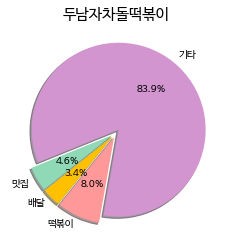

In [19]:
draw_pie_chart()